# Open to (Psychedelic) Experience:
## Targeting Potential Participants for Studies in Psychedelic Medicine

![psychedelic_mushroom.png](https://raw.githubusercontent.com/jbloewencolon/Phase-3---Open-to-Psychedelic-Experience/main/Images/bauhous%20trip.png)
    
By Jordan Loewen-Colón May 30th 2023

## The Business Problem

The (fictional) MindSpectrum Research Institute, is deeply engaged in groundbreaking work involving the clinical trials of psychedelic-assisted therapies. These trials seek to gauge the safety and effectiveness of various psychedelic substances, including psilocybin, MDMA, LSD, Ketamine, and Cannabis. These substances, when used in conjunction with psychotherapy, are being tested as potential treatments for various mental health disorders, such as depression, anxiety, post-traumatic stress disorder (PTSD), and addiction.

Our task is to assist the institute with its patient recruitment campaign, aiming to attract individuals who are not only afflicted by the targeted conditions, but are also open to the concept of psychedelic usage. The goal is to identify individuals who are naturally inclined towards trying psychedelics, without the need for excessive persuasion or influence.

In this relatively nascent field of psychedelic science, it's critical for the institute to maintain a positive public image, hence there's an inherent need to ensure that trial participants are optimally suited. The ideal participant would display an inherent willingness to try psychedelics, indicating a certain level of curiosity and a potentially positive mindset, which in turn may contribute to improved trial outcomes.

Our data science problem is to develop a predictive model focusing on 'precision' as the key performance indicator, aiming to minimize false positives in identifying potential trial participants. The institute prefers a focused approach, favoring a smaller, more reliable group of participants who are genuinely likely to experiment with psychedelics, rather than a larger group with unpredictable inclinations.

## Our Recommendations?

The Mind Spectrum Institute should **prioritize incorporating Oscore assessment** into screening processes which could improve predictions of psychedelic use, as higher scores often indicate an inclination towards such usage. Given the noticeable difference in average Oscores between psychedelic users (0.152) and non-users (-0.593), investigating Oscore's influence on therapeutic effects of psychedelic-assisted therapies could yield valuable insights. And, finally, the study should **target those who've never used legal highs, nicotine, or amyl nitrites** as potential participants for psychedelic trials.

# Step 1: Data Understanding

To make our recommendations, we analyzed the [Drug Consumptions (UCI)](https://www.kaggle.com/datasets/obeykhadija/drug-consumptions-uci) from Kaggle. As stated on the original database:

"The Database contains records for 1885 respondents. For each respondent 12 attributes are known: Personality measurements which include NEO-FFI-R (neuroticism, extraversion, openness to experience, agreeableness, and conscientiousness), BIS-11 (impulsivity), and ImpSS (sensation seeking), level of education, age, gender, country of residence and ethnicity. All input attributes are originally categorical and are quantified. After quantification values of all input features can be considered as real-valued. In addition, participants were questioned concerning their use of 18 legal and illegal drugs (alcohol, amphetamines, amyl nitrite, benzodiazepine, cannabis, chocolate, cocaine, caffeine, crack, ecstasy, heroin, ketamine, legal highs, LSD, methadone, mushrooms, nicotine and volatile substance abuse and one fictitious drug (Semeron) which was introduced to identify over-claimers. For each drug they have to select one of the answers: never used the drug, used it over a decade ago, or in the last decade, year, month, week, or day."

_____

We begin by importing the proper tools and then the data itself.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from scipy.stats import uniform, randint, pointbiserialr, ttest_ind
from tabulate import tabulate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

%matplotlib inline

# Import the data
df = pd.read_csv(r'Data/Drug_Consumption.csv', header= 0,
                        encoding= 'unicode_escape')

In [2]:
# Print the first five rows
df.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,2,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
1,3,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
2,4,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
3,5,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
4,6,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0


In [3]:
# Check Data
print(df.shape)
df.info()

(1884, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 32 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1884 non-null   int64  
 1   Age        1884 non-null   object 
 2   Gender     1884 non-null   object 
 3   Education  1884 non-null   object 
 4   Country    1884 non-null   object 
 5   Ethnicity  1884 non-null   object 
 6   Nscore     1884 non-null   float64
 7   Escore     1884 non-null   float64
 8   Oscore     1884 non-null   float64
 9   AScore     1884 non-null   float64
 10  Cscore     1884 non-null   float64
 11  Impulsive  1884 non-null   float64
 12  SS         1884 non-null   float64
 13  Alcohol    1884 non-null   object 
 14  Amphet     1884 non-null   object 
 15  Amyl       1884 non-null   object 
 16  Benzos     1884 non-null   object 
 17  Caff       1884 non-null   object 
 18  Cannabis   1884 non-null   object 
 19  Choc       1884 non-null   object 
 2

The dataset has **1884 entries and 31 columns** with a mix of **floats** and **objects**. The personality scores (6:12) is measured on a Likert-based scale ranging from 0 (“Strongly Disagree”) to 4 (“Strongly Agree”) and then rendered as a float. The demographics have various sub categories, and the drug values are measured by recency (if ever) the substance has been consumed; CL0 being never used, and CL6 being used in the last day.

In [4]:
# Check for missing values
print(f"\n {'Nulls in Column'.title()} \n {df.isnull().sum()}")

# Check for duplicate values
print(f"\n {'Duplicates'.title()} :- {len(df.loc[df.duplicated()])}")


 Nulls In Column 
 ID           0
Age          0
Gender       0
Education    0
Country      0
Ethnicity    0
Nscore       0
Escore       0
Oscore       0
AScore       0
Cscore       0
Impulsive    0
SS           0
Alcohol      0
Amphet       0
Amyl         0
Benzos       0
Caff         0
Cannabis     0
Choc         0
Coke         0
Crack        0
Ecstasy      0
Heroin       0
Ketamine     0
Legalh       0
LSD          0
Meth         0
Mushrooms    0
Nicotine     0
Semer        0
VSA          0
dtype: int64

 Duplicates :- 0


The data looks pretty clean! No duplicates or null values!

----
Looking at the data descriptions, a possible point of interest is the drug category "Semeron." The data collectors created this fictitous class of drug to weed out people who would over identify drug use as a control. Checking the values of that column, it looks like there were only about 8 over-claimers.

In [5]:
## Semeron values
print(df['Semer'].value_counts())

CL0    1876
CL2       3
CL3       2
CL1       2
CL4       1
Name: Semer, dtype: int64


It also might be worth taking a look at the means and standard deviations of our personality trait columns. Each score represents as follows:

* **Nscore** is Neuroticism
* **Escore** is Extraversion
* **Oscore** is Openness to experience.
* **Ascore** is Agreeableness.
* **Cscore** is Conscientiousness.
* **Impulsive** is impulsiveness measured by BIS-11
* **SS** is sensation seeing measured by ImpSS

In [6]:
# Select columns 5 to 12
selected_columns = df.iloc[:, 5:13]

# Calculate mean and standard deviation
mean_values = selected_columns.mean()

#Sort mean values in descending order
mean_values_sorted = mean_values.sort_values(ascending=False)

# Display the results
print("Mean values:")
print(mean_values_sorted)

Mean values:
Impulsive    0.007335
AScore       0.000242
Escore       0.000143
Nscore      -0.000119
Oscore      -0.000225
Cscore      -0.000383
SS          -0.002667
dtype: float64


Impulsive as the highest score is not surprising, however, SS (Sensation Seeking) being the lowest is.

## Step 2: Data Preperation

Since we are looking to target just psychedelic drugs, we will create a column that only includes those drugs considered under the broad definition of psychedelics: cannabis, ecstasy, ketamine, LSD, and mushrooms.

In [7]:
#Create our Target Column
df_p = df.copy()
df_p = df_p.drop(columns=['ID'])
df_p['Psychedelics'] = ''
Psychedelics = ['Cannabis','Ecstasy','Ketamine','LSD','Mushrooms']

# Create a function that determines whether or not someone has consumed a psychedelic
for i in range(0, len(df_p)):
    tot = 0
    for n in Psychedelics:
        if df_p[n][i] != "CL0":
            tot = tot + 1
        if tot > 0:
            df_p['Psychedelics'].iat[i] = 1
        else:
            df_p['Psychedelics'].iat[i] = 0

In [8]:
#Drop unnecessary columns
df_p = df_p.drop(columns=['Cannabis','Ecstasy','Ketamine','LSD','Mushrooms'], axis=1)
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           1884 non-null   object 
 1   Gender        1884 non-null   object 
 2   Education     1884 non-null   object 
 3   Country       1884 non-null   object 
 4   Ethnicity     1884 non-null   object 
 5   Nscore        1884 non-null   float64
 6   Escore        1884 non-null   float64
 7   Oscore        1884 non-null   float64
 8   AScore        1884 non-null   float64
 9   Cscore        1884 non-null   float64
 10  Impulsive     1884 non-null   float64
 11  SS            1884 non-null   float64
 12  Alcohol       1884 non-null   object 
 13  Amphet        1884 non-null   object 
 14  Amyl          1884 non-null   object 
 15  Benzos        1884 non-null   object 
 16  Caff          1884 non-null   object 
 17  Choc          1884 non-null   object 
 18  Coke          1884 non-null 

In [9]:
#Check values
print(df_p['Psychedelics'].value_counts())

1    1494
0     390
Name: Psychedelics, dtype: int64


The class imbalance here is a bit concerning, so we will probably want to run a model that accounts for that (SMOTE), and perhaps consider that as part of our parameter tuning.

In [10]:
#drop any rows of individuals claiming to take Semer
df_p.drop(df_p.loc[df_p['Semer']!='CL0'].index, inplace=True)
print(df_p['Semer'].value_counts())

CL0    1876
Name: Semer, dtype: int64


Since we are primarily focused on understanding psychedelic use based on personality scores, let's make a quick set of violin plots to get a sense of the connection.

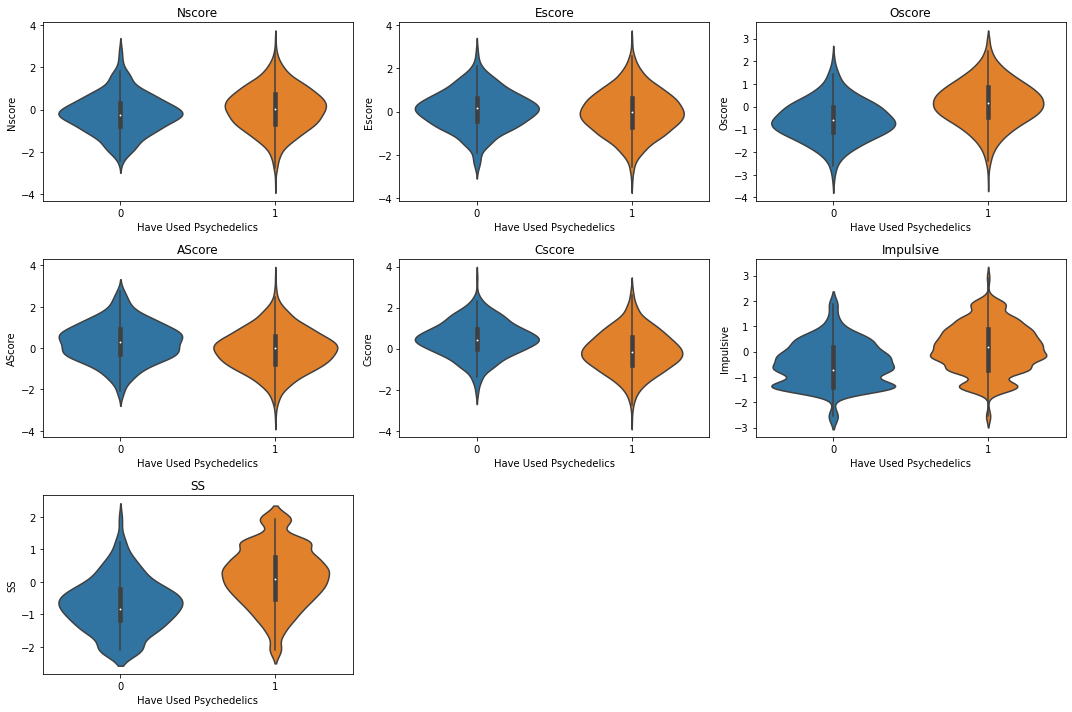

In [11]:
personality_scores = df_p.columns[5:12]

# Define the number of columns and rows for the subplots matrix
num_cols = 3  # Number of columns
num_rows = math.ceil(len(personality_scores) / num_cols)  # Number of rows

# Create the subplots matrix
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate over each numerical column
for i, column in enumerate(personality_scores):
    ax = axes[i]
    sns.violinplot(x=df_p['Psychedelics'], y=df_p[column], ax=ax)
    ax.set_xlabel('Have Used Psychedelics')
    ax.set_ylabel(column)
    ax.set_title(f'{column}')

# Hide any unused subplots
for j in range(len(personality_scores), len(axes)):
    axes[j].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

Based on these plots, we might expect there to be some strong correlation between high scorers on "Open-to-Experience" (Oscore), "Sensation Seeking" (SS), and Impulsiveness. Now let's look at the mean scores of these traits between users and non users:

In [12]:
# Select columns 5 to 12
selected_columns = df_p.iloc[:, 5:13]

# Add the 'Psychedelics' column to the selected columns
selected_columns['Psychedelics'] = df_p['Psychedelics']

# Group the data by the 'Psychedelics' column and calculate the mean
mean_values = selected_columns.groupby('Psychedelics').mean()

# Display the results
print("Mean values:")
print(mean_values)

Mean values:
                Nscore    Escore    Oscore    AScore    Cscore  Impulsive  \
Psychedelics                                                                
0            -0.186984  0.092280 -0.593444  0.293903  0.475862  -0.475498   
1             0.048167 -0.026296  0.152070 -0.077348 -0.125383   0.131627   

                    SS  
Psychedelics            
0            -0.693048  
1             0.173328  


As expected, psychedelic users score higher on Oscore and SS.

-----

Our next steps are to split the data into our training and test sets, and then create a pipeline to streamline and organize our code, enhancing readability and reproducibility. 

In [13]:
#create our train test split
y = df_p['Psychedelics']
y = y.astype('int')
X = df_p.drop(columns=['Psychedelics'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
# Print out the sizes to verify
shape_table = [['Original', X.shape, y.shape], ['Training', X_train.shape, y_train.shape], 
         ['Testing', X_test.shape, y_test.shape]]
print(tabulate(shape_table, headers=['Dataset', 'X shape', 'y shape']))

Dataset    X shape     y shape
---------  ----------  ---------
Original   (1876, 26)  (1876,)
Training   (1407, 26)  (1407,)
Testing    (469, 26)   (469,)


## Create Pipeline

In [15]:
# Create the preprocessing steps for numerical data
subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                              ('ss', StandardScaler())])

# Create the preprocessing steps for categorical data
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# Combine the preprocessing steps for numerical and categorical data
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [5, 6, 7, 8, 9, 10, 11]),
                                     ('subpipe_cat', subpipe_cat, [0, 1, 2, 3, 4, 12, 13, 14, 15, 16, 17,
                                                                    18, 19, 20, 21, 22, 23, 24, 25])],
                       remainder='passthrough')

# Step 3 - Modeling

#### Logistic Regression

Our first model will be a simple logistic regression. Starting with a logistic regression model offers interpretability and simplicity, serving as an efficient method to establish baseline performance for binary classification, such as distinguishing participants willing to try psychedelics. Its probabilistic output and capability to highlight feature importance can provide crucial insights into factors influencing willingness to participate in the trial, while setting a comparative standard for future, more complex models.

In [16]:
# Create the logistic regression model
logistic_regression_model = LogisticRegression(max_iter=10000)

# Update the pipeline to include the logistic regression model
log_pipeline = imbpipeline([
    ('preprocess', CT),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', logistic_regression_model)
])

# Fit the pipeline to the training data
log_pipeline.fit(X_train, y_train)

# Get the predicted labels for the training data
y_train_pred = log_pipeline.predict(X_train)

# Compute the precision of the logistic regression model
precision = precision_score(y_train, y_train_pred)

print(f"Precision: {precision}")

Precision: 0.9871287128712871


The log model has a **99% precision** on our training data, which implies a lower rate of false positives, as precision is the ratio of true positives to the sum of true positives and false positives. Now let's check the model on our test set:

In [17]:
# Predict the labels for the test data
y_test_pred = log_pipeline.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.66      0.91      0.76       103
           1       0.97      0.87      0.92       366

    accuracy                           0.88       469
   macro avg       0.81      0.89      0.84       469
weighted avg       0.90      0.88      0.88       469



Our model did great on the test set as well! Achieving a **97% precission** rate on determining whether a person has taken any psychedelic. It's precision wasn't as good at predicting "no" to psychedelic use, but that's less important here. Next step is to create a confusion matrix to see how many false positives and negatives we had.

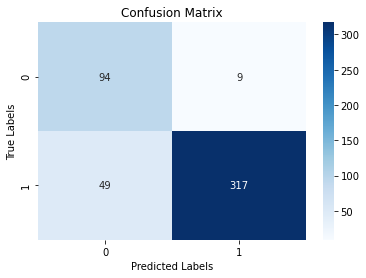

In [18]:
# Predict the labels for the test set
y_pred = log_pipeline.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Looks like the model had a total of **9 false positives**. We will keep that in mind as we explore the other models. 

Now it's time to explore the data. Our team needs to grab the feature importances in order to see which attributes the model thinks are more impotant than the others.

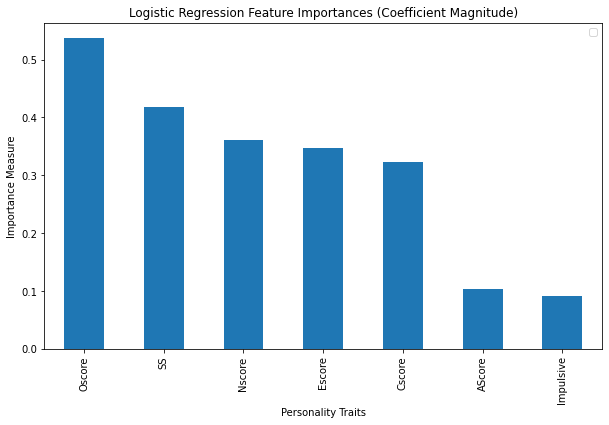

In [52]:
# Get column names after OneHotEncoding
cat_cols_transformed = log_pipeline.named_steps['preprocess'].named_transformers_['subpipe_cat'].named_steps['ohe'].get_feature_names_out(input_features=X_train.columns[[0, 1, 2, 3, 4, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]].tolist())

# Concatenate with numerical column names to get the final order
feature_names_ordered = np.concatenate([X_train.columns[5:12], cat_cols_transformed])

# Get feature coefficients from the logistic regression model
coefficients = log_pipeline.named_steps['classifier'].coef_[0]

# Create a DataFrame with feature names and their coefficients
coefficients_df = pd.DataFrame({'feature': feature_names_ordered, 'coefficient': coefficients})

# Sort DataFrame by coefficient magnitude
coefficients_df['abs_coefficient'] = abs(coefficients_df['coefficient'])
coefficients_df = coefficients_df.sort_values(by='abs_coefficient', ascending=False)

# Filter DataFrame to include only desired features
num_features_df_log = coefficients_df[coefficients_df['feature'].isin(X_train.columns[5:12])]

# Plot the feature importances for the numerical features
num_features_df_log.plot(kind='bar', x='feature', y='abs_coefficient', figsize=(10,6));
plt.xlabel('Personality Traits')
plt.ylabel('Importance Measure')
plt.title('Logistic Regression Feature Importances (Coefficient Magnitude)')
plt.legend('');

It looks like **Oscore has the largest coefficient magnitude** of all our personality traits. The coefficient value of 0.5 for "Oscore" means that for every one-unit increase, the log odds of the outcome "Psychedelics" being 'yes' (versus 'no') increase by 0.5, assuming all other variables in the model are held constant.

To better understand this in terms of odds (rather than log odds), we can calculate the odds by taking the exponent of the coefficient: exp(0.5) ≈ 1.65. This means that for every one-unit increase in "Oscore", the odds of the outcome "Psychedelics" being 'yes' (versus 'no') increase by about 65%, assuming all other variables in the model are held constant. 

And since, as we saw above, people who have taken psychedelics have a higher Oscore, we can assume that a higher Oscore means a higher likelihood that a person has consumed a psychedelic (or perhaps will).

## Random Forest Classifier

Next we run a Random Forest Classifier, or RFC. It's worth running this model due to its ability to manage overfitting, handle missing values, deal with non-linear relationships, provide feature importance, deliver high accuracy, and its versatile application to both classification and regression tasks.

In [20]:
# Create the random forest classifier model
random_forest_model = RandomForestClassifier()

# Update the pipeline to include the random forest classifier model and SMOTE
rfc_pipeline = imbpipeline([
    ('preprocess', CT),
    ('smote', SMOTE()),
    ('classifier', random_forest_model)
])

# Fit the pipeline to the training data
rfc_pipeline.fit(X_train, y_train)

# Predict the labels for the training data
y_train_pred_rfc = rfc_pipeline.predict(X_train)

# Compute the precision of the random forest model
precision_rfc = precision_score(y_train, y_train_pred_rfc)

print(f"RFC Precision: {precision_rfc}")

RFC Precision: 1.0


**A precision of 1.0 indicates that our model is probably overfitting.** To avoid that, we can run a RandomizedSearchCV to perform some hypertuning and get the best parameters for our model. Since we are targeting precision, we might want to adjust class weight values, but let's run the model first.

In [21]:
# Define the parameter grid for the random forest
param_dist = {
    'classifier__n_estimators': [100, 200, 500, 1000],
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [10, 20, 30],
    'classifier__min_samples_leaf': [4, 8, 12],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(rfc_pipeline, param_distributions=param_dist, n_iter=100, cv=5, scoring='precision', n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_

print("Best parameters:", best_params)

Best parameters: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'log2', 'classifier__max_depth': 5, 'classifier__bootstrap': True}


In [22]:
# Create a new model with the best parameters
best_rfc = RandomForestClassifier(n_estimators=best_params['classifier__n_estimators'],
                                  max_depth=best_params['classifier__max_depth'],
                                  min_samples_split=best_params['classifier__min_samples_split'],
                                  min_samples_leaf=best_params['classifier__min_samples_leaf'],
                                  max_features=best_params['classifier__max_features'],
                                  bootstrap=best_params['classifier__bootstrap'])

# Update the pipeline to include the new random forest classifier model and SMOTE
best_rfc_pipeline = imbpipeline([
    ('preprocess', CT),
    ('smote', SMOTE()),
    ('classifier', best_rfc)
])

# Fit the pipeline to the training data
best_rfc_pipeline.fit(X_train, y_train)

# Predict the labels for the training data using the best model
y_train_pred_best = best_rfc_pipeline.predict(X_train)

# Compute the precision of the best model
precision_best = precision_score(y_train, y_train_pred_best)

print(f"Best Model Training Precision: {precision_best}")

Best Model Training Precision: 0.9839195979899498


A model **precision between 96-98%** is much better! Now let's run it on the test set:

In [23]:
# Predict the labels for the test data
y_test_pred = best_rfc_pipeline.predict(X_test)

# Print the classification report for test data
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.62      0.92      0.74       103
           1       0.97      0.84      0.90       366

    accuracy                           0.86       469
   macro avg       0.80      0.88      0.82       469
weighted avg       0.90      0.86      0.87       469



Our RFC scores in a range of **95-97%** on our test set. Let's check the confusion matrix:

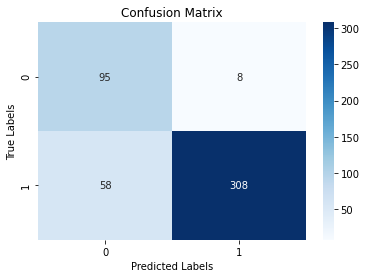

In [24]:
# Predict the labels for the test set using the best model
y_pred = random_search.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Rather than 9 false positives that our Log Model made, it looks like our RFC has anywhere from **8-10 false positives**. That's <u>potential people who would have been falsely selected</u> as likely to be willing to take psychedelics.

Let's see what this model has to say in terms of feature importances.

### Get Feature Importances

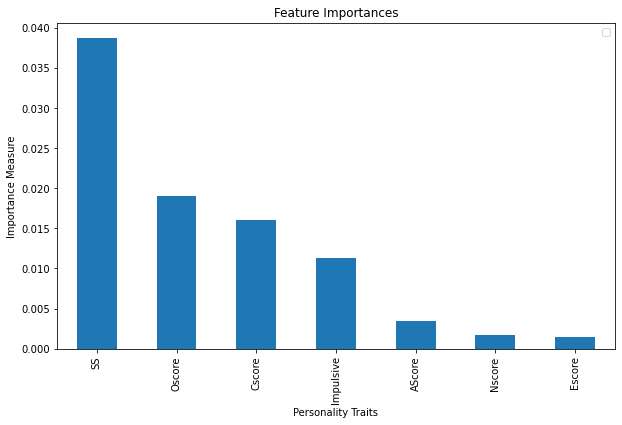

In [53]:
# Get column names after OneHotEncoding
cat_cols_transformed = random_search.best_estimator_.named_steps['preprocess'].named_transformers_['subpipe_cat'].named_steps['ohe'].get_feature_names_out(input_features=X_train.columns[[0, 1, 2, 3, 4, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]].tolist())

# Concatenate with numerical column names to get the final order
feature_names_ordered = np.concatenate([X_train.columns[5:12], cat_cols_transformed])

# Get feature importances from the best RFC
importances = random_search.best_estimator_.named_steps['classifier'].feature_importances_

# Create a DataFrame with feature names and their importance
importances_df = pd.DataFrame({'feature': feature_names_ordered, 'importance': importances})

# Sort DataFrame by importance
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Filter DataFrame to include only desired features
num_features_df_rfc = importances_df[importances_df['feature'].isin(X_train.columns[5:12])]

# Plot the feature importances for the numerical features
num_features_df_rfc.plot(kind='bar', x='feature', y='importance', figsize=(10,6))
plt.xlabel('Personality Traits')
plt.ylabel('Importance Measure')
plt.title('Feature Importances')
plt.legend('');

Unlike our log model, the **RFC seems to think SS is the most important**. Oscore is only second highest.

Now let's check our next model:

## Gradient Boosting Classifier

 Its worth running a GBC model because they are known for handling overfitting well and can provide important insights into feature importance, contributing to model interpretability, complementing insights from RFC and Logistic Regression models.

In [26]:
# Define the Gradient Boosting Classifier pipeline
gbc_pipeline = imbpipeline([
    ('preprocess', CT),
    ('smote', SMOTE()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Fit the pipeline on the training data
gbc_pipeline.fit(X_train, y_train)

# Predict the labels for the training data
y_train_pred = gbc_pipeline.predict(X_train)

# Compute the precision score
precision = precision_score(y_train, y_train_pred)

print(f"GBC Training Precision: {precision}")

GBC Training Precision: 0.9843173431734318


The initial model gives us a range of **97-98% precision**! Great! But let's see if we can make it any better with some tuning.

In [27]:
# Define the parameter distribution for the Gradient Boosting Classifier
param_dist = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__learning_rate': [0.01, 0.1, 1],
    'classifier__max_depth': randint(1, 40),
    'classifier__min_samples_split': randint(2, 11),
    'classifier__min_samples_leaf': randint(1, 5),
    'classifier__subsample': [0.5, 0.75, 1]
}

# Create the RandomizedSearchCV object
random_search_gbc = RandomizedSearchCV(gbc_pipeline, param_dist, n_iter=100, cv=5, scoring='precision', n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search_gbc.fit(X_train, y_train)

# Get the best parameters
best_params_gbc = random_search_gbc.best_params_

print("Best parameters:", best_params_gbc)

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 1, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 86, 'classifier__subsample': 1}


In [28]:
# Use the best parameters to create a new pipeline
best_gbc_model = random_search_gbc.best_estimator_.named_steps['classifier']

# Update the pipeline to include the new gradient boosting classifier model and SMOTE
best_gbc_pipeline = imbpipeline([
    ('preprocess', CT),
    ('smote', SMOTE()),
    ('classifier', best_gbc_model)
])

# Fit the pipeline to the training data
best_gbc_pipeline.fit(X_train, y_train)

# Predict the labels for the training data using the best model
y_train_pred_best_gbc = best_gbc_pipeline.predict(X_train)

# Compute the precision of the best model
precision_best_gbc = precision_score(y_train, y_train_pred_best_gbc)

print(f"Best GBC Model Precision: {precision_best_gbc}")

Best GBC Model Precision: 0.9799398194583752


It looks like that tuning gave us a **1.5% decrease**. Interesting. But how does our model do with the test data?

In [39]:
# Predict the labels for the test data
y_test_pred_gbc = best_gbc_pipeline.predict(X_test)

# Compute the precision score for the Gradient Boosting Classifier
precision_gbc = precision_score(y_test, y_test_pred_gbc)

# Print the classification report for test data
print(classification_report(y_test, y_test_pred_gbc))

              precision    recall  f1-score   support

           0       0.61      0.90      0.73       103
           1       0.97      0.84      0.90       366

    accuracy                           0.85       469
   macro avg       0.79      0.87      0.81       469
weighted avg       0.89      0.85      0.86       469



Looks like our GBC model was overfitting. It scores between a **96-97% for precision** with our test data. The confusion matrix indicates 10-13 false positives.

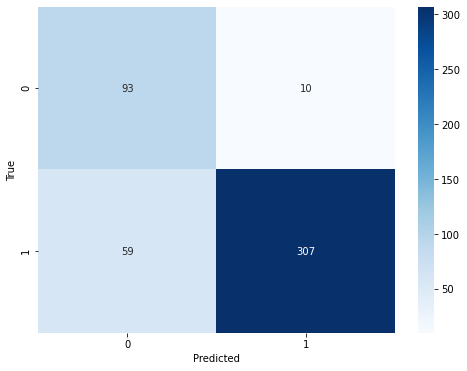

In [40]:
# Generate the predictions for the test set
y_test_pred_gbc = best_gbc_pipeline.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_gbc)

# Display the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

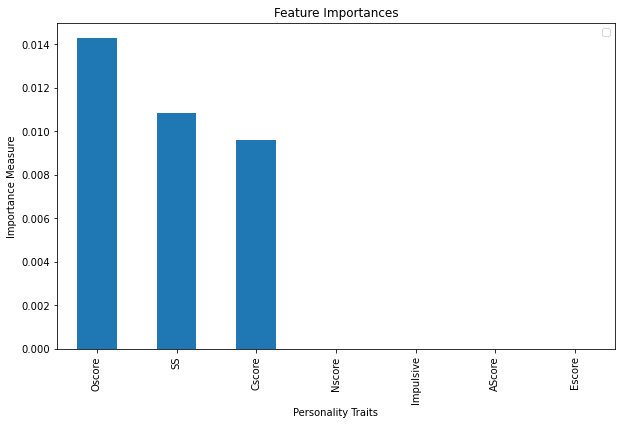

In [54]:
# Get column names after OneHotEncoding
cat_cols_transformed = best_gbc_pipeline.named_steps['preprocess'].named_transformers_['subpipe_cat'].named_steps['ohe'].get_feature_names_out(input_features=X_train.columns[[0, 1, 2, 3, 4, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]].tolist())

# Concatenate with numerical column names to get the final order
feature_names_ordered = np.concatenate([X_train.columns[5:12], cat_cols_transformed])

# Get feature importances from the Gradient Boosting Classifier in the final pipeline
importances = best_gbc_pipeline.named_steps['classifier'].feature_importances_

# Check if the lengths of feature names and importances match
assert len(importances) == len(feature_names_ordered), "Lengths of feature names and importances do not match."

# Create a DataFrame with feature names and their importance
importances_df = pd.DataFrame({'feature': feature_names_ordered, 'importance': importances})

# Sort DataFrame by importance
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Filter DataFrame to include only desired features
num_features_df_gbc = importances_df[importances_df['feature'].isin(X_train.columns[5:12])]

# Plot the feature importances for the numerical features
num_features_df_gbc.plot(kind='bar', x='feature', y='importance', figsize=(10,6))
plt.xlabel('Personality Traits')
plt.ylabel('Importance Measure')
plt.title('Feature Importances')
plt.legend('');

Like our Log model, the **GBC thinks Oscore is the most important** however it looks like a few of the traits had such low scores they didn't even register.

## Model Comparison

In [32]:
# Define the models and their predictions
models = [('Logistic Regression', log_pipeline), ('RFC', best_rfc_pipeline), ('GBC', best_gbc_pipeline)]

# Define the evaluation metrics
metrics = [('accuracy', accuracy_score), ('precision', precision_score),
           ('recall', recall_score), ('F1-score', f1_score)]

# Iterate over models and metrics to compute and print the scores
for model_name, model in models:
    predictions = model.predict(X_test)
    print(f"\nModel: {model_name}")
    for metric_name, metric_func in metrics:
        score = metric_func(y_test, predictions)
        print(f"{metric_name}: {score}")


Model: Logistic Regression
accuracy: 0.8763326226012793
precision: 0.9723926380368099
recall: 0.8661202185792349
F1-score: 0.9161849710982659

Model: RFC
accuracy: 0.8571428571428571
precision: 0.9746031746031746
recall: 0.8387978142076503
F1-score: 0.9016152716593245

Model: GBC
accuracy: 0.8528784648187633
precision: 0.9684542586750788
recall: 0.8387978142076503
F1-score: 0.8989751098096632


When comparing all our models, it looks like our **Logistical Regression model scores highest on accuracy, and F1**. The RFC model scored highest on precision and recall. While the scores are close, we'll give the Log model the edge and choose it to draw understandings. And if we compare feature importances focused on personality scores?

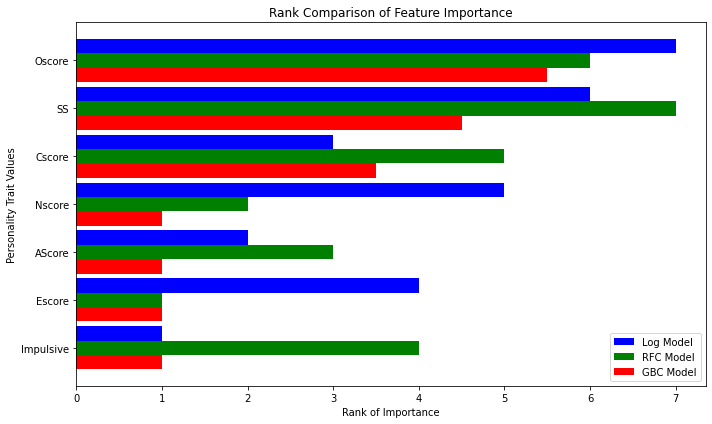

In [33]:
def rank_dataframe(df, column_name):
    ranked_df = df.copy()
    # Compute ranks
    ranked_df['rank'] = ranked_df[column_name].rank(ascending=False)
    # Invert ranks
    max_rank = ranked_df['rank'].max()
    ranked_df['rank'] = max_rank + 1 - ranked_df['rank']
    ranked_df = ranked_df.sort_values(by='feature')
    return ranked_df

# Create ranked dataframes using the function
num_features_df_log_ranked = rank_dataframe(num_features_df_log, 'abs_coefficient')
num_features_df_rfc_ranked = rank_dataframe(num_features_df_rfc, 'importance')
num_features_df_gbc_ranked = rank_dataframe(num_features_df_gbc, 'importance')

# Calculate the average rank for each feature
average_rank = (num_features_df_log_ranked['rank'] + num_features_df_rfc_ranked['rank'] + num_features_df_gbc_ranked['rank']) / 3

# Create a new dataframe with the average ranks
average_rank_df = pd.DataFrame({'feature': num_features_df_log_ranked['feature'], 'average_rank': average_rank})

# Sort the average_rank_df by the average rank, in descending order
average_rank_df = average_rank_df.sort_values(by='average_rank', ascending=False)

# Get the order of the features based on the sorted average_rank_df
order = average_rank_df['feature']

# Set 'feature' as the index for the dataframes, so you can reorder the rows to match the average rank
num_features_df_log_ranked.set_index('feature', inplace=True)
num_features_df_rfc_ranked.set_index('feature', inplace=True)
num_features_df_gbc_ranked.set_index('feature', inplace=True)

# Reorder the rows in the dataframes to match the order in average_rank_df
num_features_df_log_ranked = num_features_df_log_ranked.loc[order]
num_features_df_rfc_ranked = num_features_df_rfc_ranked.loc[order]
num_features_df_gbc_ranked = num_features_df_gbc_ranked.loc[order]

# Reset the index for the dataframes, so 'feature' is a column again
num_features_df_log_ranked.reset_index(inplace=True)
num_features_df_rfc_ranked.reset_index(inplace=True)
num_features_df_gbc_ranked.reset_index(inplace=True)

def plot_ranked_data(df1, df2, df3, label1, label2, label3):
    features = df1['feature']
    rank1 = df1['rank']
    rank2 = df2['rank']
    rank3 = df3['rank']

    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.3

    ax.barh(np.arange(len(features)), rank1, width, label=label1, color='b')
    ax.barh(np.arange(len(features)) + width, rank2, width, label=label2, color='g')
    ax.barh(np.arange(len(features)) + 2*width, rank3, width, label=label3, color='r')

    ax.set_xlabel('Rank of Importance')
    ax.set_ylabel('Personality Trait Values')
    ax.set_title('Rank Comparison of Feature Importance')
    ax.set_yticks(np.arange(len(features))[::-1] + width)  # Invert the y-axis ticks
    ax.set_yticklabels(features[::-1])  # Reverse the order of feature labels
    ax.legend()

    plt.tight_layout()
    plt.gca().invert_yaxis()  # Invert the y-axis

    plt.show()

# Call the function to plot the data
plot_ranked_data(num_features_df_log_ranked, num_features_df_rfc_ranked, num_features_df_gbc_ranked, 'Log Model', 'RFC Model', 'GBC Model')

This chart provides a comparison of feature importance rankings across the three different models: 'Log Model', 'RFC Model', and 'GBC Model'. Each horizontal bar represents a feature used in the models. The bar's length and the corresponding rank number represent the relative importance of each feature according to the specific model. The higher the rank number, the higher the importance.

Features are ordered in descending order based on the average ranking score of all three models, with the feature having the highest average rank (i.e., most often identified as important across all models) at the top.

Two of the models agree that Oscore is the most important, and on average, find "Impulsivness" the least important.

## Step 4 - Data Understanding
#### Digging Deeper into our Logistical Regression Model


First, let's get the coefficient values in our model. We probably don't need them all, but let's check for about 30 to see where our personality scores end up compared to all the other variables in terms of importance.

In [43]:
# Add a new column 'rank' with the feature rankings
coefficients_df['rank'] = range(1, len(coefficients_df) + 1)

# Set the index as the 'rank' column
coefficients_df = coefficients_df.set_index('rank')

# Drop the 'coefficient' column
coefficients_df.drop('coefficient', axis=1, inplace=True)

# Display the most influential features
print(coefficients_df.head(35))

                                                feature  abs_coefficient
rank                                                                    
1                                            Legalh_CL0         2.190091
2                                          Nicotine_CL0         1.914194
3                                              Coke_CL0         1.900637
4                                            Amphet_CL0         1.830429
5                                              Amyl_CL0         1.718720
6                                            Amphet_CL1         1.529359
7                                              Coke_CL1         1.333646
8                                           Alcohol_CL0         1.303689
9                                          Nicotine_CL3         1.120546
10                                           Legalh_CL1         0.993306
11                          Ethnicity_Mixed-White/Asian         0.929565
12                                             Amyl

Out of the 130 coefficients, our Oscore is in the top 35, but there is a signifigant difference between it and our leading coefficients: Never Having Taken a Legal Highs, Nicotine, and Cocaine. A question to ask is, do people who take psychedelics and have NEVER taken a Legal High score higher on openness than non-psychedelic consumers?

In [44]:
# Filter the dataset for individuals who scored 'CL0' in the 'Legalh' column
cl0_data = df_p[df_p['Legalh'] == 'CL0']

# Calculate the average 'Oscore' for individuals who scored 'CL0' in the 'Legalh' column and are categorized as 'Psychedelics'
average_oscore_cl0_psychedelics = cl0_data[cl0_data['Psychedelics'] == 1]['Oscore'].mean()
average_oscore_cl0_psychedelics = round(average_oscore_cl0_psychedelics, 2)

# Calculate the average 'Oscore' for individuals who scored 'CL0' in the 'Legalh' column and are categorized as non-psychedelics
average_oscore_cl0_non_psychedelics = cl0_data[cl0_data['Psychedelics'] == 0]['Oscore'].mean()
average_oscore_cl0_non_psychedelics = round(average_oscore_cl0_non_psychedelics, 2)

# Calculate the average 'Oscore' for all other results in the 'Legalh' column
average_oscore_other = df_p[df_p['Legalh'] != 'CL0']['Oscore'].mean()
average_oscore_other = round(average_oscore_other, 2)

# Print the results
print(f"The average Oscore for individuals who scored 'CL0' in the Legalh column and are categorized as 'Psychedelics' is: {average_oscore_cl0_psychedelics}")
print(f"The average Oscore for individuals who scored 'CL0' in the Legalh column and are categorized as non-psychedelics is: {average_oscore_cl0_non_psychedelics}")
print(f"The average Oscore for all other results in the Legalh column is: {average_oscore_other}")

The average Oscore for individuals who scored 'CL0' in the Legalh column and are categorized as 'Psychedelics' is: -0.13
The average Oscore for individuals who scored 'CL0' in the Legalh column and are categorized as non-psychedelics is: -0.6
The average Oscore for all other results in the Legalh column is: 0.41


Looks like **psychedelic users who have not taken Legal Highs score higher on the Oscore than non-psychedelic users (-.13 vs -.6)**! So that indicates that Oscore possibly contributes positively to Psychedelic use in conjunction with our most important coefficient. However, it looks like the average Legal High users scores even higher. That means we will want to filter them out. But what about Oscore more generally?

In [36]:
# Calculate the average 'Oscore' for individuals who take psychedelics
average_oscore_psychedelics = df_p[df_p['Psychedelics'] == 1]['Oscore'].mean()
average_oscore_psychedelics = round(average_oscore_psychedelics, 2)

# Calculate the average 'Oscore' for individuals who do not take psychedelics
average_oscore_non_psychedelics = df_p[df_p['Psychedelics'] == 0]['Oscore'].mean()
average_oscore_non_psychedelics = round(average_oscore_non_psychedelics, 2)

# Print the results
print(f"The average 'Oscore' for individuals who take psychedelics is: {average_oscore_psychedelics}")
print(f"The average 'Oscore' for individuals who do not take psychedelics is: {average_oscore_non_psychedelics}")

The average 'Oscore' for individuals who take psychedelics is: 0.15
The average 'Oscore' for individuals who do not take psychedelics is: -0.59


So it looks like, generally speaking, **psychedelic users are more likely to have a higher Oscore than non-psychedelic users**. Let's visualize this further with a density plot:

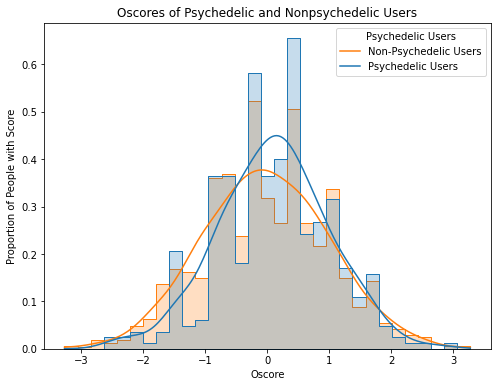

In [37]:
df_p["category"] = y
grouped = df_p.groupby("category")

plt.figure(figsize=(8, 6))

sns.histplot(df_p, x=df_p.columns[6], hue="category", element="step", stat="density", common_norm=False, kde=True)

plt.ylabel('Proportion of People with Score')
plt.xlabel('Oscore')
plt.title('Oscores of Psychedelic and Nonpsychedelic Users')

plt.legend(title='Psychedelic Users', labels=['Non-Psychedelic Users', 'Psychedelic Users'])
plt.show()

## Conclusions and Recommendations

Our first recommedation involves **Recruitment Strategy**. The precision of 97% achieved by the logistic regression model indicates that the model is effective in identifying potential trial participants who are genuinely likely to experiment with psychedelics. **The institute can focus on targeting individuals who exhibit characteristics associated with high precision, such as never having taken legal highs, nicotine, or cocaine.** These factors can be used as screening criteria during the recruitment process.

Our second recommendation involves the **importance of the Oscore**. The Oscore coefficient with a magnitude of 0.5 compared to the other personality traits indicates that it is one of the significant predictors of psychedelic use. This model indicates that individuals with higher Oscores tend to be more inclined towards using psychedelics. **Therefore, considering an individual's Oscore can contribute positively to the prediction of psychedelic usage.** The institute can incorporate the assessment of Oscore into the screening process to further refine the selection of potential participants.

Our final recommendation involves a **comparison of Oscore and psychedelic use**. The analysis of the average Oscore for individuals who take psychedelics and those who do not reveals a notable difference. Individuals who take psychedelics have an average Oscore of 0.152, while those who do not have an average Oscore of -0.593. This indicates that Oscore may be a relevant factor in understanding the inclination towards psychedelic use. **The institute can explore further research to investigate the relationship between Oscore and the therapeutic effects of psychedelic-assisted therapies**.

### Next Steps

Our logistic regression model may have scored so high for two reasons:
1) Because log regressions assume that there's a linear decision boundary between the classes, while decision trees (and by extension, Random Forests and Gradient Boosting models) do not, If the data indeed has a linear decision boundary, logistic regression might outperform more complex models.

2) Random Forest and Gradient Boosting models are more complex than logistic regression, and this complexity can lead them to overfit the training data, especially if the dataset is small, which ours is.

Therefore, getting more data might actually allow our more complex models to provide more precise predictions.

### Additional Visualizations

A bar chart comparing precision scores among all three models:

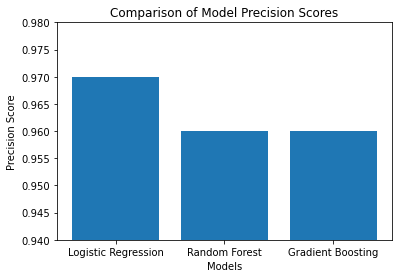

In [47]:
# Precision scores of all three models
logistic_regression_precision = 0.97
random_forest_precision = 0.96
gradient_boosting_precision = 0.96

# Define the models
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

# Define the precision scores
precision_scores = [logistic_regression_precision, random_forest_precision, gradient_boosting_precision]

# Create a bar chart
plt.bar(models, precision_scores)

# Add title and labels
plt.title('Comparison of Model Precision Scores')
plt.xlabel('Models')
plt.ylabel('Precision Score')

# Adjust the range of y-axis
plt.ylim(.94, .98)

# Show the plot
plt.show()